In [59]:
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
adata = ad.read_h5ad("../data/testdata/test4_qcplots/test4_input/adata_log2_cont_filter.h5ad")

# Density Plot

In [ ]:
def density_plots(adata, color_by):
    
    adata_copy = adata.copy()
    assert color_by in adata_copy.obs.columns, f"{color_by} not found in adata.obs"

    df = pd.DataFrame(data=adata_copy.X, columns=adata_copy.var_names, index=adata_copy.obs[color_by])
    df.reset_index(inplace=True)
    df = pd.melt(df, id_vars=color_by, var_name="Protein", value_name="Abundance")  
    sns.kdeplot(data=df, x="Abundance",hue=color_by, multiple="layer", common_norm=False)

In [146]:
adata.obs.columns

Index(['Slide', 'Scene', 'Number of cells', 'Area µm^2', 'name_of_class',
       'calibs', '384_software_well', 'Column', '384_hardware_well',
       'samples_and_wells', 'well check', '96_well'],
      dtype='object')

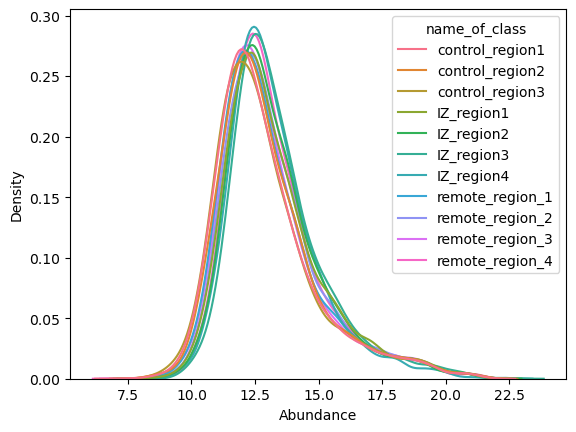

In [147]:
density_plots(adata, "name_of_class")

# Rank Plot

In [46]:
adata = ad.read_h5ad("../data/testdata/test4_qcplots/test4_input/adata_log2_cont_filter.h5ad")

In [95]:
adata.obs.columns

Index(['Slide', 'Scene', 'Number of cells', 'Area µm^2', 'name_of_class',
       'calibs', '384_software_well', 'Column', '384_hardware_well',
       'samples_and_wells', 'well check', '96_well'],
      dtype='object')

In [117]:
from adjustText import adjust_text

In [ ]:
def rankplot(adata, key_adataobs, val_adataobs, key_adatavar, label_adatavar ):
    
    adata_copy = adata.copy()
    
    assert key_adatavar in adata_copy.var.columns, f"{key_adatavar} not in adata.var"

    if key_adataobs is not None:
        assert key_adataobs in adata_copy.obs.columns, f"{key_adataobs} not in adata.obs"
        adata_copy = adata_copy[adata_copy.obs[key_adataobs] == val_adataobs].copy()

    df_tmp = pd.DataFrame(data=adata_copy.X, columns=adata_copy.var[key_adatavar])
    df_tmp = df_tmp.T
    df_tmp['mean'] = df_tmp.mean(axis=1)
    df_tmp.sort_values(by='mean', ascending=False, inplace=True)
    df_tmp.reset_index(inplace=True)
    df_tmp['rank'] = df_tmp.index +1
        
    #plot
    fig, ax = plt.subplots()
    sns.scatterplot(data=df_tmp, x='rank', y='mean', hue='mean', palette='flare', ax=ax, linewidth=0)
    ax.get_legend().remove()

    if label_adatavar is not None:
        
        texts = []
        for gene in label_adatavar:
            x = df_tmp.loc[df_tmp[key_adatavar] == gene, 'rank']
            y = df_tmp.loc[df_tmp[key_adatavar] == gene, 'mean']
            texts.append(ax.text(x, y, gene, ha='center', va='center'))
        adjust_text(texts, expand=(1, 3), arrowprops=dict(arrowstyle='->', color='red'))
    
    plt.show()

/opt/homebrew/Caskroom/mambaforge/base/envs/proteomics/lib/python3.12/site-packages/matplotlib/text.py:756: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/opt/homebrew/Caskroom/mambaforge/base/envs/proteomics/lib/python3.12/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/opt/homebrew/Caskroom/mambaforge/base/envs/proteomics/lib/python3.12/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/opt/homebrew/Caskroom/mambaforge/base/envs/proteomics/lib/python3.12/site-packages/matplotlib/text.py:898: FutureW

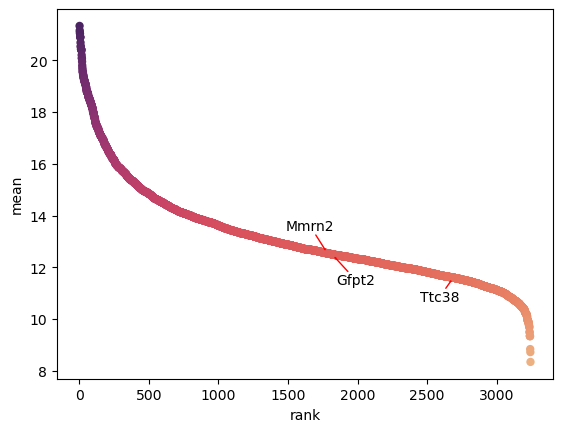

In [144]:
rankplot(adata=adata, key_adataobs="Slide", val_adataobs=1, key_adatavar="Genes", label_adatavar=['Gfpt2','Ttc38','Mmrn2'])

# Coefficient of variation

In [148]:
adata = ad.read_h5ad("../data/testdata/test4_qcplots/test4_input/adata_log2_cont_filter.h5ad")

In [149]:
adata

AnnData object with n_obs × n_vars = 11 × 3244
    obs: 'Slide', 'Scene', 'Number of cells', 'Area µm^2', 'name_of_class', 'calibs', '384_software_well', 'Column', '384_hardware_well', 'samples_and_wells', 'well check', '96_well'
    var: 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description'

In [150]:
adata.X

array([[10.41770486, 11.76372693, 10.37675487, ..., 11.03702524,
        13.13391923, 12.28196479],
       [12.90908865,         nan,         nan, ..., 10.66267728,
        13.29598412, 12.17550277],
       [11.53193699, 11.98256227,  9.74151249, ..., 10.22717067,
        13.17279782, 12.25683671],
       ...,
       [        nan, 12.16603752, 10.07702931, ..., 10.72137266,
        13.04408328, 12.13315506],
       [13.10076252, 12.16795749, 10.25649177, ..., 10.2503458 ,
        12.65052   , 12.29109874],
       [        nan, 12.47041485, 10.89916808, ...,         nan,
        13.41574177,         nan]])

In [166]:
def coefficient_of_variation(adata, group_by):
        
    adata_copy = adata.copy()
    assert group_by in adata_copy.obs.columns, f"{group_by} not found in adata.obs"
    
    df_tmp = pd.DataFrame()

    for group in adata.obs[group_by].unique():
        print(group)
        #print warning if group has less than 3 samples
        adata_group = adata_copy[adata_copy.obs[group_by] == group].copy()
        if adata_group.X.shape[0] < 3:
            print(f"{group} in dataset has less than 3 samples, leading to poor statistics")
        adata_group.var['mean'] = np.mean(adata_group.X, axis=0)
        adata_group.var['std'] = np.std(adata_group.X, axis=0)
        adata_group.var['cv'] = adata_group.var['mean']/adata_group.var['std']
        
        adata_copy.var[f"{group}_cv"] = adata_group.var['cv']

        df_tmp = pd.concat([df_tmp,adata_group.var['cv']], axis=0)
        df_tmp[group_by] = group

    #plot
    sns.boxplot(data=df_tmp, x=group_by, y="cv")


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

def coefficient_of_variation(adata, group_by):
    adata_copy = adata.copy()
    assert group_by in adata_copy.obs.columns, f"{group_by} not found in adata.obs"

    # Temporary DataFrame to store CV values for plotting
    df_tmp = pd.DataFrame()

    for group in adata.obs[group_by].unique():
        
        # Extract group-specific data
        adata_group = adata_copy[adata_copy.obs[group_by] == group].copy()
        
        # Warn if less than 3 samples in the group
        print(f"this group has {adata_group.shape[0]} samples")
        if adata_group.shape[0] < 3:
            print(f"{group} in dataset has less than 3 samples, leading to poor statistics")
        
        # Calculate mean, std, and cv for each feature in the group
        means = np.mean(adata_group.X, axis=0) #does this ignore NaNs? 
        stds = np.std(adata_group.X, axis=0)
        cvs = stds / means  # CV = std / mean

        # Store results in adata_copy.var
        adata_copy.var[f"{group}_mean"] = means
        adata_copy.var[f"{group}_std"] = stds
        adata_copy.var[f"{group}_cv"] = cvs

        # Append to df_tmp for plotting
        group_df = pd.DataFrame({f"{group}_cv": cvs, group_by: group})
        df_tmp = pd.concat([df_tmp, group_df], ignore_index=True)

    # Plot using seaborn
    df_tmp = df_tmp.melt(id_vars=group_by, var_name='metric', value_name='cv')
    sns.boxplot(data=df_tmp, y="cv", hue=group_by, width=0.3)

2
this group has 3 samples
1
this group has 8 samples


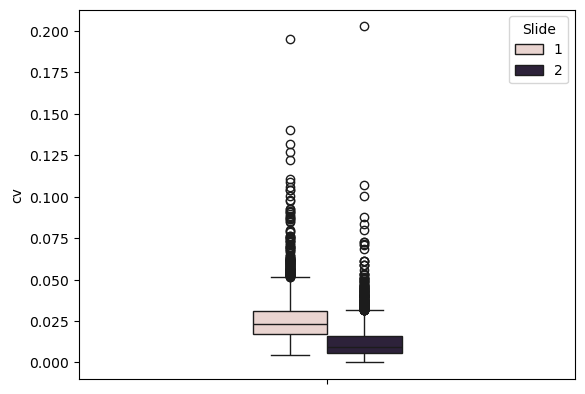

In [175]:
coefficient_of_variation(adata, group_by="Slide")